In [1]:
import pandas as pd
import numpy as np


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                 names = ['age','workclass','finalweight','education','edunum','maritalstatus', 'occupation','relationship',
                         'race','sex','capgain','caploss','hrsperwk','country','income'])


##initial feature engineering: setting our target variable to binary
##defining netcap as a new combination of capgain - caploss
##dropping 'finalweight', defined as # of individuals census believed represented by that class

df['incomestatus'] = np.where(df['income']==' <=50K',0 ,1)
df['netcap'] = (df['capgain']-df['caploss'])
df.drop(['income','capgain','caploss','finalweight','relationship','workclass'], axis=1, inplace=True)

In [2]:
##functions for cleaning up dataframe

def married(row):
    if row['msMarAFspouse'] == 1 or row['msMarCivSpouse'] == 1 or row['msMarSpouseAbsent'] == 1:
        val = 1
    else:
        val = 0
    return val

def whitecollar(row):
    if row['oExecmanager'] == 1 or row['oProfSpecialty'] == 1 or row['oSales'] == 1 or ['oTech'] == 1:
        val = 1
    else:
        val = 0
    return val

def race(row):
    if row['raceWhite'] == 1:
        val = 1
    else:
        val = 0
    return val

def sexchange(x):
    if x == ' Male':
        return 1
    elif x == ' Female':
        return 0
    

In [3]:
#we have 3 categorical variable columns: maritalstatus, occupation, and race
#we will keep all of the observations with unknown values for now

#generating dummy variable dataframes for each column
df_maritalstatus = pd.get_dummies(df['maritalstatus']) ##married/divorced
df_occupation = pd.get_dummies(df['occupation']) ##Execmanager, ProfSpeciality, Sales, Tech
df_race = pd.get_dummies(df['race']) ##race white/nonwhite


#generating new column names for each dummy var column
df_maritalstatus.columns = ['msDivorced','msMarAFspouse','msMarCivSpouse','msMarSpouseAbsent','msNeverMar','msSeparated','msWidowed']
df_occupation.columns = ['oUnknown','oAdmClerical','oArmforces','oCraftrepair','oExecmanager','oFarmFish','oHandlersCleaners',
                        'oMachOpInspect','oOtherService','oPrivHouseServ','oProfSpecialty','oProtectiveServ','oSales','oTech','oTransport']
df_race.columns = ['raceAmerIndian','raceAsian','raceBlack','raceOther','raceWhite']

#combining dummy variables to binary columns to reduce features
df['married'] = df_maritalstatus.apply(married, axis=1)
df['job_category'] = df_occupation.apply(whitecollar, axis=1)
df['racewhite?'] = df_race.apply(race, axis=1)
df['sex'] = df['sex'].apply(sexchange)



In [4]:
#dropping now obsolete categorical columns
df.drop(['occupation','maritalstatus','race'], axis=1, inplace=True)


,age,education,edunum,sex,hrsperwk,country,incomestatus,netcap,married,job_category,racewhite?
0,39,Bachelors,13,1,40,United-States,0,2174,0,0,1
1,50,Bachelors,13,1,13,United-States,0,0,1,1,1
2,38,HS-grad,9,1,40,United-States,0,0,0,0,1
3,53,11th,7,1,40,United-States,0,0,1,0,0
4,28,Bachelors,13,0,40,Cuba,0,0,1,1,0
5,37,Masters,14,0,40,United-States,0,0,1,1,1
6,49,9th,5,0,16,Jamaica,0,0,1,0,0
7,52,HS-grad,9,1,45,United-States,1,0,1,1,1
8,31,Masters,14,0,50,United-States,1,14084,0,1,1
9,42,Bachelors,13,1,40,United-States,1,5178,1,1,1


In [5]:
##binning the categorical education data and the corresponding edunum feature

bins = [1, 5, 9, 11, 14, 16]
edu_levels = ['gradeschool','someHS','HSgrad','collegeDeg','advanced']

##gradeSchool: preschool, 1st-4th, 5th-6th, 7th-8th
##someHS: 9th, 10th, 11th, 12th
##HSgrad: hs-grad, some-college
##collegeDeg: assoc_voc, assoc_acdm, bachelors
##advanced: masters, prof-school, Doctorate

eduLevel = pd.cut(df['edunum'], bins, labels=edu_levels)
df['eduLevel'] = pd.cut(df['edunum'], bins, labels=edu_levels)

##creating the dummy vars and dropping the original columns

df_edu = pd.get_dummies(df['eduLevel'])
df_edu.columns = ['elCollegeDeg','elSomeHS','elGradeschool','elHSgrad','elAdvanced']
df = pd.concat([df, df_edu], axis=1)
df.drop(['education','edunum','eduLevel'], axis=1, inplace=True)

In [6]:
##separating country feature into 'developed' economies 1, or non-developed 0

developed = ['United-States','Puerto-Rico','Outlying-US(Guam-USVI-etc)',
             'Japan','Italy','Germany','England','France','Canada']

def richcountries(x):
    if x.strip() in developed:
        return 1
    else:
        return 0
    
df['country'] = df['country'].apply(richcountries)


,age,sex,hrsperwk,country,incomestatus,netcap,married,job_category,racewhite?,elCollegeDeg,elSomeHS,elGradeschool,elHSgrad,elAdvanced
0,39,1,40,1,0,2174,0,0,1,0.0,0.0,0.0,1.0,0.0
1,50,1,13,1,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0
2,38,1,40,1,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0
3,53,1,40,1,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0
4,28,0,40,0,0,0,1,1,0,0.0,0.0,0.0,1.0,0.0


In [7]:
##moving the target variable column to the end of the df
temp = df['incomestatus']
df.drop('incomestatus',axis=1,inplace=True)
df = pd.concat((df, temp),axis=1)

,age,sex,hrsperwk,country,netcap,married,job_category,racewhite?,elCollegeDeg,elSomeHS,elGradeschool,elHSgrad,elAdvanced,incomestatus
0,39,1,40,1,2174,0,0,1,0.0,0.0,0.0,1.0,0.0,0
1,50,1,13,1,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0
2,38,1,40,1,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0
3,53,1,40,1,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0
4,28,0,40,0,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0


In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from collections import defaultdict
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from collections import defaultdict
from pprint import pprint
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import normalize,scale,MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import seaborn
import nltk
from sklearn import cross_validation


%matplotlib inline

In [9]:
##progress tracker function borrowed from stack overflow

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
##define target variable and feature matrix

y = df.incomestatus
X=df.drop(['incomestatus'],1)

In [93]:
##Lasso regularization for feature engineering

from sklearn.linear_model import Lasso
def lasso_regression(X, y, alpha):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(X,y)
    y_pred = lassoreg.predict(X)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-y)**2)
    coefs = lassoreg.coef_
    return zip(X.columns, coefs)



In [96]:
lasso_regression(X,y,alpha=1e-15)

[('age', 0.0027394165948469089),
 ('sex', 0.03284284599775765),
 ('hrsperwk', 0.0030053563887524485),
 ('country', 0.04940434116639051),
 ('netcap', 7.4710482699124296e-06),
 ('married', 0.28561839187893301),
 ('job_category', 0.10864079242455842),
 ('racewhite?', 0.017133548941809473),
 ('elCollegeDeg', 0.001833246062489144),
 ('elSomeHS', 0.10491571272603033),
 ('elGradeschool', 0.16853605938569582),
 ('elHSgrad', 0.28718701416176357),
 ('elAdvanced', 0.44411840075414954)]

In [97]:
df.corr()

,age,sex,hrsperwk,country,netcap,married,job_category,racewhite?,elCollegeDeg,elSomeHS,elGradeschool,elHSgrad,elAdvanced,incomestatus
age,1.000000,0.088832,0.068756,0.030335,0.074284,0.318239,0.084792,0.033412,0.105913,-0.032692,-0.105120,0.051324,0.096008,0.234037
sex,0.088832,1.000000,0.229309,-0.015025,0.045846,0.421465,-0.002048,0.103486,0.034251,0.007090,-0.064531,0.017833,0.056733,0.215980
hrsperwk,0.068756,0.229309,1.000000,0.006524,0.075207,0.210912,0.143836,0.049345,-0.031661,-0.057752,-0.055907,0.100981,0.097461,0.229689
country,0.030335,-0.015025,0.006524,1.000000,0.003860,-0.033275,0.046055,0.215671,-0.216146,0.056990,0.058394,0.003098,-0.025379,0.046091
netcap,0.074284,0.045846,0.075207,0.003860,1.000000,0.079600,0.104048,0.013238,-0.024990,-0.058978,-0.036176,0.051842,0.162985,0.214428
married,0.318239,0.421465,0.210912,-0.033275,0.079600,1.000000,0.094264,0.096347,0.030905,-0.040311,-0.070476,0.067816,0.085923,0.434944
job_category,0.084792,-0.002048,0.143836,0.046055,0.104048,0.094264,1.000000,0.073395,-0.136282,-0.294088,-0.059772,0.385117,0.203023,0.291823
racewhite?,0.033412,0.103486,0.049345,0.215671,0.013238,0.096347,0.073395,1.000000,-0.019760,-0.029032,0.000962,0.035361,0.019336,0.085224
elCollegeDeg,0.105913,0.034251,-0.031661,-0.216146,-0.024990,0.030905,-0.136282,-0.019760,1.000000,-0.189517,-0.139701,-0.133910,-0.041035,-0.101523
elSomeHS,-0.032692,0.007090,-0.057752,0.056990,-0.058978,-0.040311,-0.294088,-0.029032,-0.189517,1.000000,-0.492536,-0.472119,-0.144674,-0.192119


In [98]:
X=X.drop(['racewhite?','country','elGradeschool'],1)

In [99]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4444)

#standardizing data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [107]:
models = [LogisticRegression(), GaussianNB(),
          KNeighborsClassifier(n_neighbors=15), LinearSVC(random_state=4444), RandomForestClassifier(random_state=4444)]

def modelEval(models):
    averages = []
    for model in log_progress(models, every=1):
        f1scores = cross_val_score(model, X_std, y, cv=10, scoring='f1')
        accscores = cross_val_score(model, X_std, y, cv=10, scoring='accuracy')
        prescores = cross_val_score(model, X_std, y, cv=10, scoring='precision')
        recscores = cross_val_score(model, X_std, y, cv=10, scoring='recall')
        temp = [str(model).split('(')[0],accscores.mean(),recscores.mean(),prescores.mean(),f1scores.mean()]
        averages.append(temp)

        
    scoredf = pd.DataFrame(averages,columns=['algorithm', 'accuracy','recall','precision','f1'])
    return scoredf



In [108]:
modelEval(models)

,algorithm,accuracy,recall,precision,f1
0,LogisticRegression,0.838150,0.556562,0.709042,0.623531
1,GaussianNB,0.834680,0.482720,0.740626,0.584406
2,KNeighborsClassifier,0.837106,0.557070,0.704994,0.622160
3,LinearSVC,0.839133,0.541130,0.721441,0.618313
4,RandomForestClassifier,0.837597,0.592653,0.689729,0.637322


In [105]:
def find_k(x_train,y_train,x_test,y_test):
    KNNscores=[]
    for n in range(1,30):
        neigh = KNeighborsClassifier(n_neighbors=n)
        neigh.fit(x_train,y_train)
        KNNscores.append(recall_score(y_test,neigh.predict(x_test)))
    return KNNscores.index(max(KNNscores))+1

In [106]:
#find_k(X_train_std, y_train, X_test_std, y_test)

15

In [118]:
#plot confusion matrix
model = RandomForestClassifier(random_state=4444)
model.fit(X_train_std, y_train)
predictions = model.predict(X_test_std)
true_vals = y_test

cm = confusion_matrix(true_vals,predictions)

In [126]:
connor = [23, 1, 40, 2600, 0, 1, 1, 0, 0, 0]
connorStatus = model.predict(connor)
print connorStatus

[1]


In [124]:
X.columns

Index([u'age', u'sex', u'hrsperwk', u'netcap', u'married', u'job_category',
       u'elCollegeDeg', u'elSomeHS', u'elHSgrad', u'elAdvanced'],
      dtype='object')

In [115]:
##setting up roc curve

from sklearn import metrics

lr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=1)
rf = RandomForestClassifier(random_state=4444)


lr.fit(X_train_std, y_train)
nb.fit(X_train_std, y_train)
knn.fit(X_train_std, y_train)
rf.fit(X_train_std, y_train)


predslr = lr.predict_proba(X_test_std)[:,1]
predsnb = nb.predict_proba(X_test_std)[:,1]
predsknn = knn.predict_proba(X_test_std)[:,1]
predsrf = rf.predict_proba(X_test_std)[:,1]



fprlr, tprlr, _ = metrics.roc_curve(y_test, predslr)
fprnb, tprnb, _ = metrics.roc_curve(y_test, predsnb)
fprknn, tprknn, _ = metrics.roc_curve(y_test, predsknn)
fprrf, tprrf, _ = metrics.roc_curve(y_test, predsrf)


lrdf = pd.DataFrame(dict(fpr=fprlr, tpr=tprlr))
nbdf = pd.DataFrame(dict(fpr=fprnb, tpr=tprnb))
knndf = pd.DataFrame(dict(fpr=fprknn, tpr=tprknn))
rfdf = pd.DataFrame(dict(fpr=fprrf, tpr=tprrf))



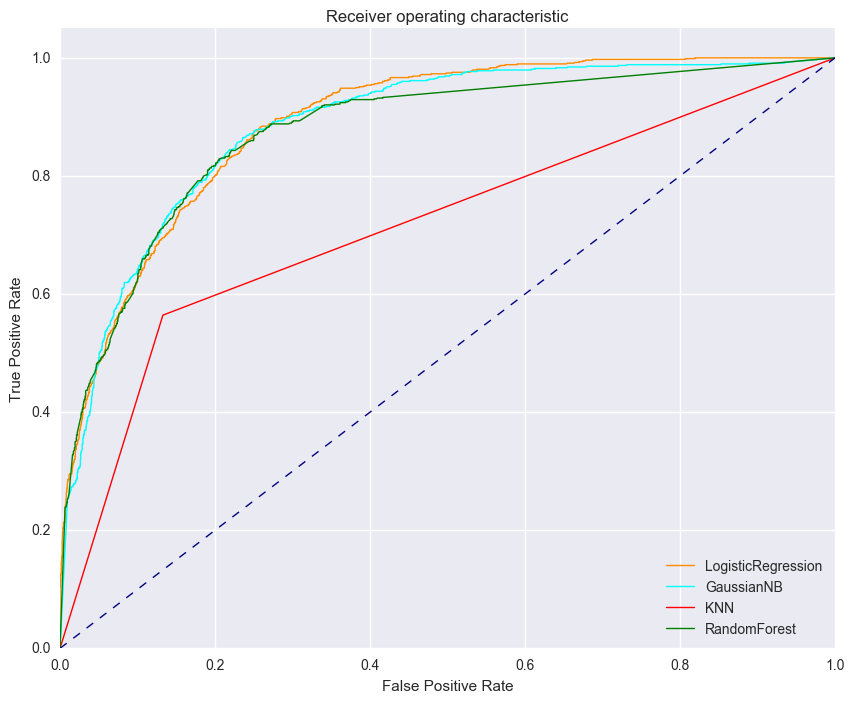

In [116]:
##plotting roc curve

plt.figure(figsize=(10, 8))
lw = 1
plt.plot(lrdf.fpr, lrdf.tpr , color='darkorange',
         lw=lw, label='LogisticRegression')
plt.plot(nbdf.fpr, nbdf.tpr , color='cyan',
         lw=lw, label='GaussianNB')
plt.plot(knndf.fpr, knndf.tpr , color='red',
         lw=lw, label='KNN')
plt.plot(rfdf.fpr, rfdf.tpr , color='green',
         lw=lw, label='RandomForest')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [121]:
##plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.91327148  0.08672852]
 [ 0.41388175  0.58611825]]


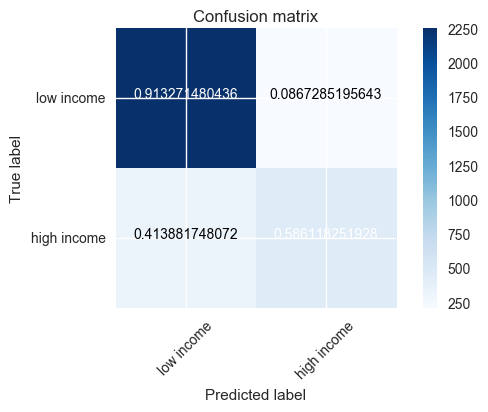

In [122]:
import itertools
plot_confusion_matrix(cm,classes=["low income",'high income'])